In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.realpath(".."))
from DejaVu.explib.read_model import read_model

Using backend: pytorch


In [2]:
from pathlib import Path
exp_dir = Path('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451')

In [41]:
from DejaVu.models import get_GAT_model
model, y_probs, y_preds = read_model(
    exp_dir,
    get_GAT_model,
    override_config=dict(data_dir=Path("/SSF/data/A1"), flush_dataset_cache=False)
)

cdp = fdg = model.fdg
config = model.config
cache = model.cache

output_dir = config.output_dir / 'DT_explain'
output_dir.mkdir(exist_ok=True, parents=True)
print(output_dir)

2022-03-09 12:33:30.696 | DEBUG    | utils.load_model:best_checkpoint:19 - path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451') metric='val_loss' mode='min'
2022-03-09 12:33:30.739 | DEBUG    | utils.load_model:best_checkpoint:40 - ckpt_path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=449-A@1=0.647059-val_loss=0.296444-MAR=2.235294.ckpt') has metrics: {'epoch': '449', 'A@1': '0.647059', 'val_loss': '0.296444', 'MAR': '2.235294'}
2022-03-09 12:33:30.739 | DEBUG    | utils.load_model:best_checkpoint:40 - ckpt_path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=119-A@1=0.882353-val_loss=0.346040-MAR=1.470588.ckpt') has metrics: {'epoch': '119', 'A@1': '0.882353', 'val_loss': '0.346040', 'MAR': '1.470588'}
2022-03-09 12:33:30.740 | DEBUG    | utils.lo

/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/DT_explain


In [33]:
from DejaVu.explanability.dt_follow import train_feature_extractor_decoder
import torch as th
decoder_path = output_dir / 'decoder.pt'
if not decoder_path.exists():
    th.save(train_feature_extractor_decoder(model=model), decoder_path)
decoder = th.load(decoder_path)

In [51]:
from DejaVu.explanability import select_useful_columns
import torch as th
from pprint import pformat
import json
import torch
import pandas as pd

useful_columns_path = output_dir / 'useful_columns.txt'
if not useful_columns_path.exists() or True:
    useful_columns, diff, rec_loss_df = select_useful_columns(
        model=model, threshold=0.1,
        decoder=decoder
    )
    with open(useful_columns_path, 'w+') as f:
        json.dump(list(useful_columns), f)
    diff.to_pickle(output_dir / "diff.pkl")
with open(useful_columns_path, 'r') as f:
    useful_columns = set(json.load(f))
diff = pd.read_pickle(output_dir / "diff.pkl")

2022-03-10 01:57:27.360 | INFO     | DejaVu.explanability.dt_follow:select_useful_columns:138 - Get reconstructed X
2022-03-10 01:57:27.643 | INFO     | DejaVu.explanability.dt_follow:select_useful_columns:145 - Prepare Dataframe
2022-03-10 01:57:33.542 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='variance_larger_than_standard_deviation'
2022-03-10 01:57:33.543 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='ratio_beyond_r_sigma'
2022-03-10 01:57:33.544 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='large_standard_deviation'
2022-03-10 01:57:33.545 | DEBUG    | DejaVu.explanability.ts_feature:__init__:38 - del fname='symmetry_looking'
2022-03-10 01:57:33.545 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='has_duplicate_max'
2022-03-10 01:57:33.545 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='has_duplicate_min'
2022-03-10 01:57:33.546 | DEBUG    | DejaVu.explanabilit

In [75]:
diff_df = pd.DataFrame(diff, columns=["diff"])
diff_df["metric_kind"] = diff_df.index.map(lambda _: _.split("__")[0].split("##")[1])
diff_df

,diff,metric_kind
db_003 Load##ACS__variance_larger_than_standard_deviation,NaN,ACS
db_003 Load##ACS__has_duplicate_max,0.620690,ACS
db_003 Load##ACS__has_duplicate_min,0.461538,ACS
db_003 Load##ACS__has_duplicate,0.644068,ACS
db_003 Load##ACS__sum_values,3.722155,ACS
...,...,...
os_022##succ_rate__permutation_entropy__dimension_4__tau_1,2.000000,succ_rate
os_022##succ_rate__permutation_entropy__dimension_5__tau_1,2.000000,succ_rate
os_022##succ_rate__permutation_entropy__dimension_6__tau_1,2.000000,succ_rate
os_022##succ_rate__permutation_entropy__dimension_7__tau_1,2.000000,succ_rate


In [93]:
import numpy as np
rec_loss_df["rel_loss"] = rec_loss_df.apply(lambda _: _["loss"] / np.maximum(np.mean(np.square(_["x"])), 1e-12), axis=1)
rec_loss_df["metric_kind"] = rec_loss_df["metric"].map(lambda _: _.split("##")[1])
rec_loss_df

,metric,fid,x,rec_x,loss,rel_loss,metric_kind
0,db_003##cost,5,"[-0.0015266881, -0.0013657883, -0.0016768555, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.180657e-06,1.000000e+00,cost
1,db_003##count,5,"[0.07419373, 0.077850394, -0.030331796, -0.074...","[-0.021830272, 0.06143063, 0.007832164, -0.018...",7.817297e-02,1.403068e-01,count
2,db_003##proc,5,"[-0.023141898, -0.020645969, -0.025476899, -0....","[-8.4519386e-05, -0.0001462698, -0.00022822618...",4.972439e-04,9.789560e-01,proc
3,db_003##succ_rate,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004167676, 0.0067287087, 0.010253727, 0.012...",2.362916e-03,2.362916e+09,succ_rate
4,db_007##cost,5,"[0.015388725, 0.0031105196, 0.00941589, -0.020...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.992272e-02,1.000000e+00,cost
...,...,...,...,...,...,...,...
39045,os_021##succ_rate,38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.5258789e-05, 2.9355288e-05, 4.258752e-05, 5...",3.504250e-06,1.043151e+00,succ_rate
39046,os_022##cost,38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02364266, -0.0434103, -0.060472846, -0.075...",1.566170e+00,9.055407e-01,cost
39047,os_022##count,38,"[0.09669539, -0.019804947, 0.06672326, -0.0890...","[-0.0024981499, -0.0060335994, -0.0108110905, ...",3.868820e-01,5.397556e-01,count
39048,os_022##proc,38,"[-0.13735844, 0.047966722, -0.117300935, -0.25...","[-1.1324883e-06, -2.5629997e-06, -4.23193e-06,...",5.797865e-02,1.000190e+00,proc


In [101]:
metric_kind_rec_loss_df = rec_loss_df.groupby("metric_kind")[["rel_loss"]].median()
metric_kind_rec_loss_df

,rel_loss
metric_kind,
ACS,1.000130e+00
AIOS,5.035813e+03
AWS,1.000165e+00
Agent_ping,4.693957e+03
Asm_Free_Tb,7.570446e+01
...,...
fake,9.327363e+03
proc,4.564941e-01
ss_total,1.046275e+00


In [ ]:
useful_columns

In [6]:
import numpy as np
from loguru import logger
import torch as th

######################################
mode = 'simple_fctype'
######################################
dataloader = model.train_dataloader_orig()
encoder = model.module.feature_projector
logger.info("Get reconstructed X")
feat, *_ = tuple(zip(*dataloader))
feat = [th.cat(_, dim=0) for _ in list(zip(*feat))]
device = next(encoder.parameters()).device
feat = [_.to(device) for _ in feat]
decoder.to(device)
z = encoder(feat)
rec_x = decoder(z)

logger.info("Prepare Dataframe")
orig_ts_df_records = []
rec_ts_df_records = []
rec_loss_df_records = []
for i, fault_id in enumerate(dataloader.dataset.fault_ids):
    for j in range(cdp.n_failure_instances):
        node = cdp.gid_to_instance(j)
        node_type, typed_id = cdp.gid_to_local_id(j)
        node_type_idx = cdp.failure_classes.index(node_type)
        for k, metric in enumerate(cdp.FC_metrics_dict[node_type]):
            _feat = feat[node_type_idx][i, typed_id, k, :].detach().cpu().numpy()
            _rec_x = rec_x[node_type_idx][i, typed_id, k, :].detach().cpu().numpy()
            orig_ts_df_records.extend(
                [{
                    'kind': f"{node}##{metric}", 'time': t, 'id': fault_id, 'value': v.item(),
                } for t, v in enumerate(_feat)]
            )
            rec_ts_df_records.extend(
                [{
                    'kind': f"{node}##{metric}", 'time': t, 'id': fault_id, 'value': v.item(),
                } for t, v in enumerate(_rec_x)]
            )
            rec_loss_df_records.append(
                {
                    "metric": f"{node}##{metric}",
                    "x": _feat,
                    "fid": fault_id,
                    "rec_x": _rec_x,
                    "loss": np.mean(np.square(_feat - _rec_x)),
                }
            )
import pandas as pd
orig_df = pd.DataFrame.from_records(orig_ts_df_records)
rec_df = pd.DataFrame.from_records(rec_ts_df_records)
rec_loss_df = pd.DataFrame.from_records(rec_loss_df_records)
del orig_ts_df_records, rec_ts_df_records
from tsfresh import extract_features
if mode == 'full':
    default_fc_parameters = None
elif mode == 'simple':
    from DejaVu.explanability import SimpleFCParameters
    default_fc_parameters = SimpleFCParameters()
elif mode == 'simple_fctype':
    from DejaVu.explanability.ts_feature import SimpleFCTypeFCParameters
    default_fc_parameters = SimpleFCTypeFCParameters()
elif mode == 'minimal':
    from tsfresh.feature_extraction import MinimalFCParameters
    default_fc_parameters = MinimalFCParameters()
else:
    raise RuntimeError(f"unknown ts feature extraction mode: {mode=}")

logger.info("Get TS features")
orig_ts_feats = extract_features(
    orig_df, column_id='id', column_sort='time', column_kind='kind', column_value='value',
    default_fc_parameters=default_fc_parameters,
)
rec_ts_feats = extract_features(
    rec_df, column_id='id', column_sort='time', column_kind='kind', column_value='value',
    default_fc_parameters=default_fc_parameters,
)

2022-02-17 11:35:08.643 | INFO     | __main__:<module>:10 - Get reconstructed X
2022-02-17 11:35:09.268 | INFO     | __main__:<module>:19 - Prepare Dataframe
2022-02-17 11:35:17.802 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='variance_larger_than_standard_deviation'
2022-02-17 11:35:17.805 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='ratio_beyond_r_sigma'
2022-02-17 11:35:17.805 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='large_standard_deviation'
2022-02-17 11:35:17.806 | DEBUG    | DejaVu.explanability.ts_feature:__init__:38 - del fname='symmetry_looking'
2022-02-17 11:35:17.807 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='has_duplicate_max'
2022-02-17 11:35:17.808 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='has_duplicate_min'
2022-02-17 11:35:17.809 | DEBUG    | DejaVu.explanability.ts_feature:__init__:41 - keep fname='has_duplicate'
2022-02-17 11:35:1

In [8]:
import pickle
with open(output_dir / "orig_ts_feats.pkl", "wb+") as f:
    pickle.dump(orig_ts_feats, f)
with open(output_dir / "rec_ts_feats.pkl", "wb+") as f:
    pickle.dump(rec_ts_feats, f)
with open(output_dir / "rec_loss_df.pkl", "wb+") as f:
    pickle.dump(rec_loss_df, f)

In [23]:
import pickle
with open(output_dir / "orig_ts_feats.pkl", "rb") as f:
    orig_ts_feats = pickle.load(f)
with open(output_dir / "rec_ts_feats.pkl", "rb") as f:
    rec_ts_feats = pickle.load(f)
with open(output_dir / "rec_loss_df.pkl", "rb") as f:
    rec_loss_df = pickle.load(f)

In [25]:
rec_loss_df["metric_kind"] = rec_loss_df.metric.map(lambda _: _.split("##")[1])
grouped_rec_loss_df = rec_loss_df.groupby("metric_kind")[["loss"]].mean().sort_values(by="loss")
grouped_rec_loss_df

,loss
metric_kind,
Sent_errors_packets,4.344152e-11
Received_errors_packets,4.694129e-11
fake,3.221232e-10
container_fgct,9.331521e-10
container_thread_idle,3.157454e-09
...,...
Sent_queue,2.764706e+00
Redo_Per_Sec,3.184833e+00
Disk_await,3.646796e+00


In [8]:
import numpy as np
diff = 2 * np.mean(
    np.square(rec_ts_feats.values - orig_ts_feats), axis=0
) / np.mean(
    np.square(rec_ts_feats.values + orig_ts_feats), axis=0
)
diff

docker_007##cost__variance_larger_than_standard_deviation          NaN
docker_007##cost__has_duplicate_max                           0.048780
docker_007##cost__has_duplicate_min                           0.000000
docker_007##cost__has_duplicate                               0.095238
docker_007##cost__sum_values                                  0.844613
                                                                ...   
os_022##succ_rate__permutation_entropy__dimension_4__tau_1    1.791300
os_022##succ_rate__permutation_entropy__dimension_5__tau_1    1.811824
os_022##succ_rate__permutation_entropy__dimension_6__tau_1    1.831025
os_022##succ_rate__permutation_entropy__dimension_7__tau_1    1.822439
os_022##succ_rate__mean_n_absolute_max__number_of_maxima_7    1.679842
Length: 132398, dtype: float64

In [27]:
diff_df = pd.DataFrame(diff, columns=["feat_diff"])
diff_df["metric_kind"] = diff_df.index.map(lambda _: _.split("__")[0].split("##")[1])
diff_df["feature_name"] = diff_df.index.map(lambda _: _.split("##")[1])
grouped_diff_df = diff_df.groupby(["feature_name", "metric_kind"])[["feat_diff"]].mean().reset_index()
grouped_diff_df

,feature_name,metric_kind,feat_diff
0,ACS__abs_energy,ACS,1.980242
1,ACS__absolute_maximum,ACS,1.723813
2,ACS__absolute_sum_of_changes,ACS,1.963576
3,ACS__approximate_entropy__m_2__r_0.1,ACS,0.411679
4,ACS__approximate_entropy__m_2__r_0.3,ACS,0.636767
...,...,...,...
24313,tnsping_result_time__value_count__value_0,tnsping_result_time,2.000000
24314,tnsping_result_time__value_count__value_1,tnsping_result_time,2.000000
24315,tnsping_result_time__variance,tnsping_result_time,1.999929
24316,tnsping_result_time__variance_larger_than_stan...,tnsping_result_time,2.000000


In [28]:
df = grouped_diff_df.join(grouped_rec_loss_df, on="metric_kind")
df["score"] = df.eval("feat_diff * loss")
df

,feature_name,metric_kind,feat_diff,loss,score
0,ACS__abs_energy,ACS,1.980242,0.031401,0.062182
1,ACS__absolute_maximum,ACS,1.723813,0.031401,0.054130
2,ACS__absolute_sum_of_changes,ACS,1.963576,0.031401,0.061658
3,ACS__approximate_entropy__m_2__r_0.1,ACS,0.411679,0.031401,0.012927
4,ACS__approximate_entropy__m_2__r_0.3,ACS,0.636767,0.031401,0.019995
...,...,...,...,...,...
24313,tnsping_result_time__value_count__value_0,tnsping_result_time,2.000000,0.475950,0.951900
24314,tnsping_result_time__value_count__value_1,tnsping_result_time,2.000000,0.475950,0.951900
24315,tnsping_result_time__variance,tnsping_result_time,1.999929,0.475950,0.951866
24316,tnsping_result_time__variance_larger_than_stan...,tnsping_result_time,2.000000,0.475950,0.951900


In [39]:
useful_columns = set(df[(df.loss > 0.5) & (df.feat_diff < 0.5)]["feature_name"].values)

In [106]:
from DejaVu.explanability import dt_follow
from DejaVu.dataset import prepare_sklearn_dataset
config.flush_dataset_cache=False
dt_follow(
    cdp, output_dir / "with_feature_selection", prepare_sklearn_dataset(
        cdp, config, cache, mode='simple_fctype'
    ), useful_columns, y_probs, prune=False,
)
dt_follow(
    cdp, output_dir / "without_feature_selection", prepare_sklearn_dataset(
        cdp, config, cache, mode='simple_fctype'
    ), None, y_probs, prune=False,
)

2022-03-11 10:16:34.732 | WARNING  | failure_dependency_graph.model_interface:get_metric_preprocessor:105 - Use cached metric preprocessor
2022-03-11 10:16:35.998 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:209 - fault ids with multiple root causes: []
2022-03-11 10:16:35.999 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:234 - fault_type=('Docker CPU',)                
train_length=7     train_ids=[5, 23, 12, 37, 0, 58, 30] 
validation_length=4     validation_ids=[75, 29, 3, 15] 
test_length=8     test_ids=[65, 59, 18, 50, 44, 41, 8, 52] 
(7   recurring faults)
2022-03-11 10:16:36.000 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:234 - fault_type=('Docker',)                    
train_length=12    train_ids=[35, 25, 56, 71, 53, 17, 13, 9, 6, 1, 7, 26] 
validation_length=6     validation_ids=[2, 21, 63, 68, 70, 54] 
test_length=12    test_ids=[24, 31, 28, 77, 48, 49, 16, 67, 76, 62, 60, 69] 
(1

{'DB Session': DecisionTreeClassifier(),
 'DB State': DecisionTreeClassifier(),
 'Docker': DecisionTreeClassifier(),
 'Docker CPU': DecisionTreeClassifier(),
 'Docker FULL GC': DecisionTreeClassifier(),
 'Docker Memory': DecisionTreeClassifier(),
 'Docker Session': DecisionTreeClassifier(),
 'Docker Thread': DecisionTreeClassifier(),
 'OS': DecisionTreeClassifier(),
 'OS Network': DecisionTreeClassifier()}

## LR explain

In [6]:
lr_output_dir = (output_dir / ".." / "lr_explain").resolve()
lr_output_dir.mkdir(exist_ok=True, parents=True)
print(f"{lr_output_dir=}")

lr_output_dir=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lr_explain')


In [52]:
from DejaVu.explanability.dt_follow import lr_follow
from DejaVu.dataset import prepare_sklearn_dataset
config.flush_dataset_cache=False
feature_importance_dict = lr_follow(
    cdp, lr_output_dir, prepare_sklearn_dataset(
        cdp, config, cache, mode='simple_fctype'
    ), useful_columns, y_probs,
)

2022-02-23 07:10:28.125 | WARNING  | failure_dependency_graph.model_interface:get_metric_preprocessor:105 - Use cached metric preprocessor
2022-02-23 07:10:29.307 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:209 - fault ids with multiple root causes: []
2022-02-23 07:10:29.308 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:234 - fault_type=('Docker CPU',)                
train_length=7     train_ids=[5, 23, 12, 37, 0, 58, 30] 
validation_length=4     validation_ids=[75, 29, 3, 15] 
test_length=8     test_ids=[65, 59, 18, 50, 44, 41, 8, 52] 
(7   recurring faults)
2022-02-23 07:10:29.309 | INFO     | failure_dependency_graph.model_interface:split_failures_by_type:234 - fault_type=('Docker',)                    
train_length=12    train_ids=[35, 25, 56, 71, 53, 17, 13, 9, 6, 1, 7, 26] 
validation_length=6     validation_ids=[2, 21, 63, 68, 70, 54] 
test_length=12    test_ids=[24, 31, 28, 77, 48, 49, 16, 67, 76, 62, 60, 69] 
(1

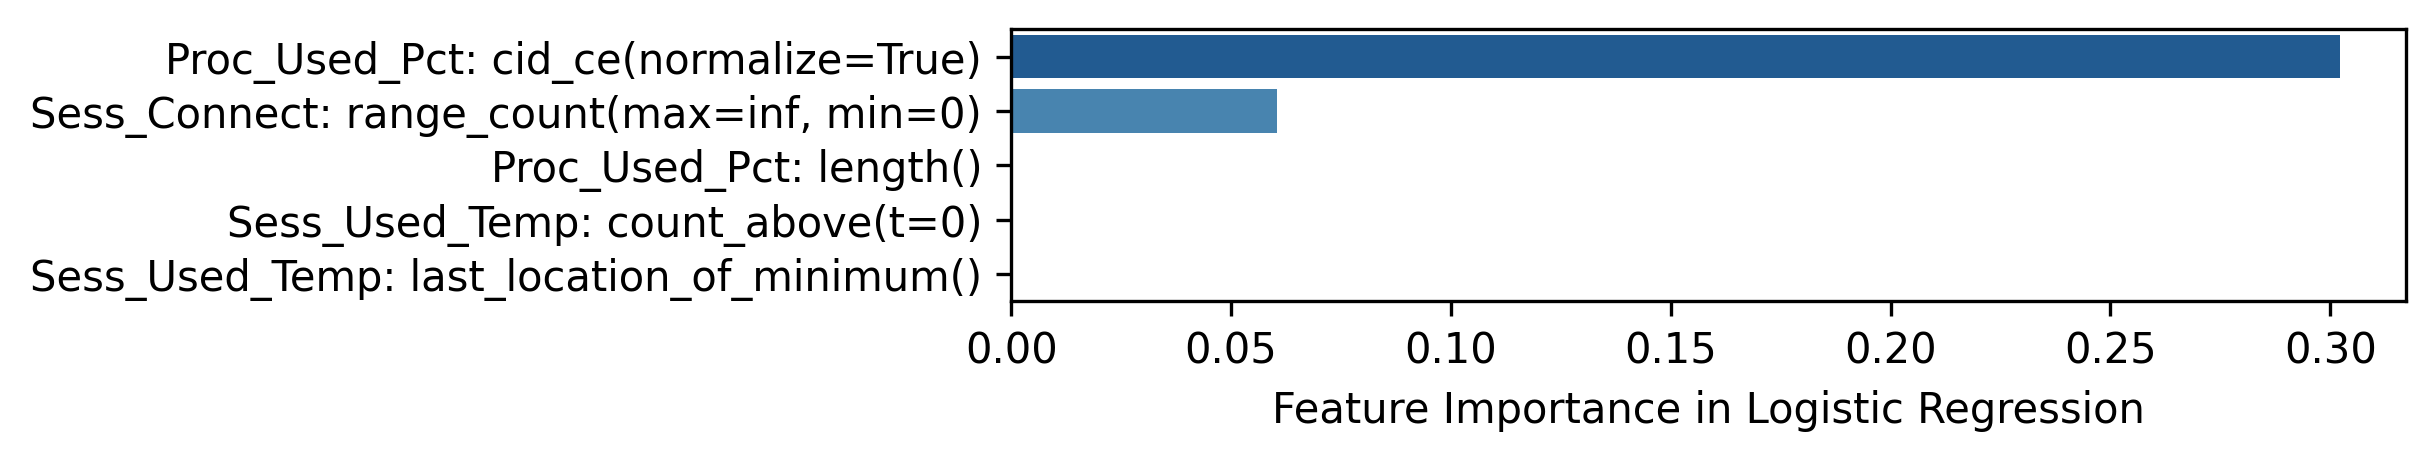

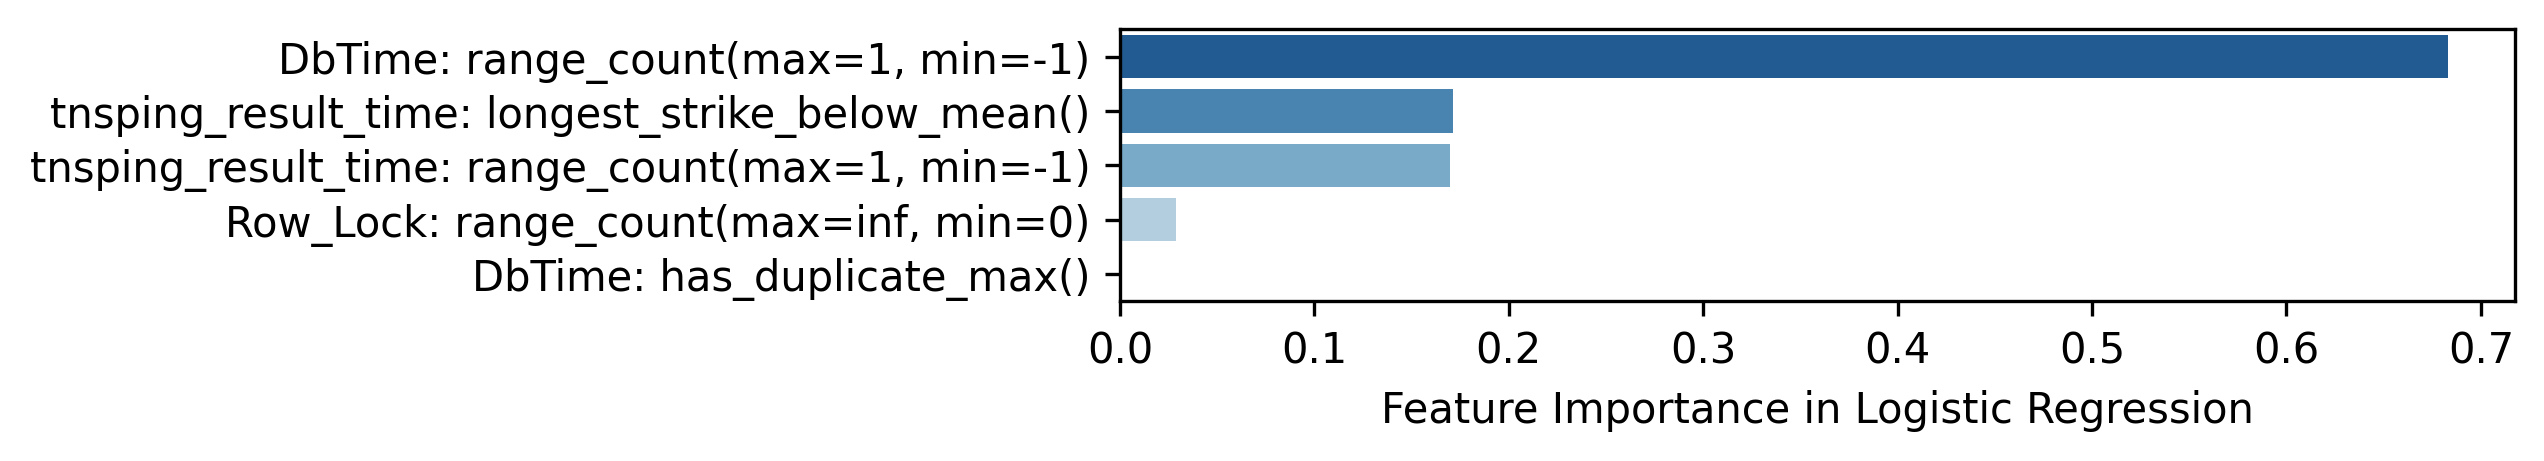

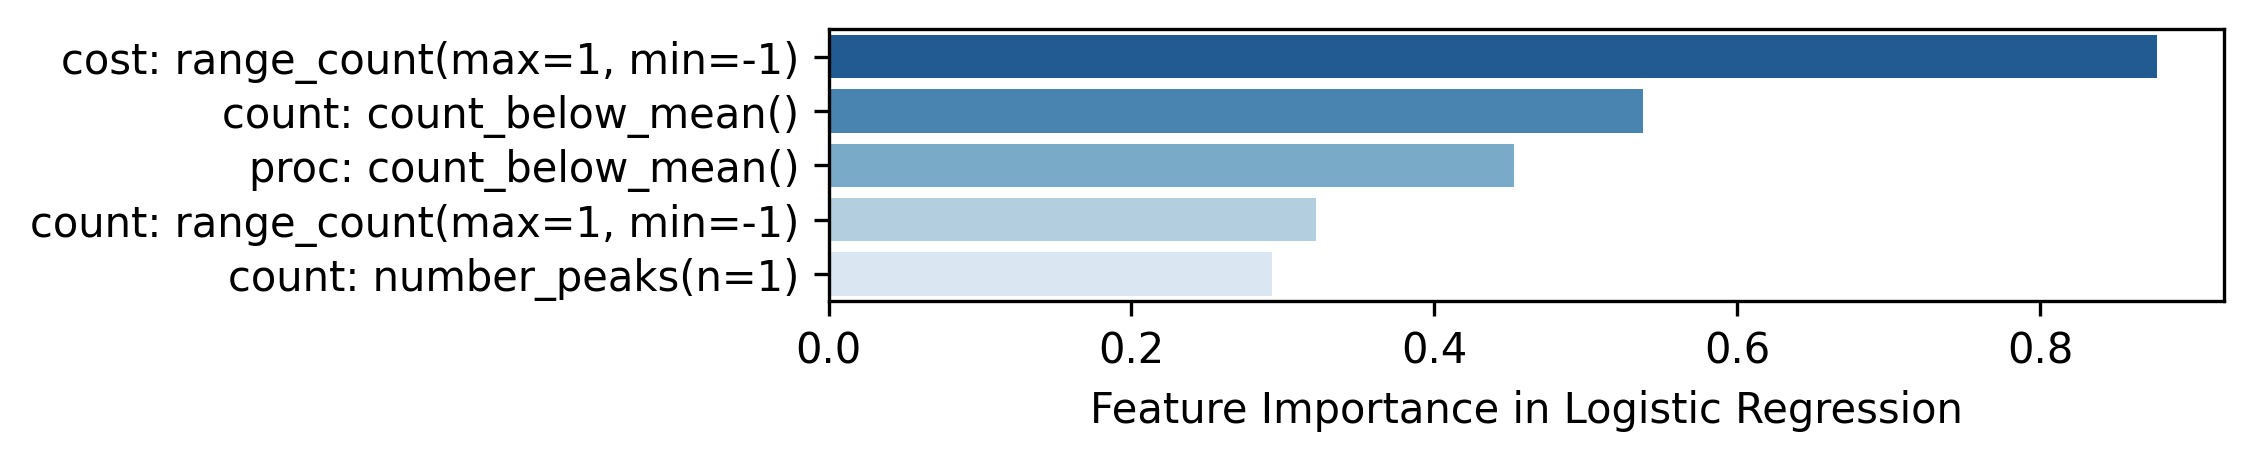

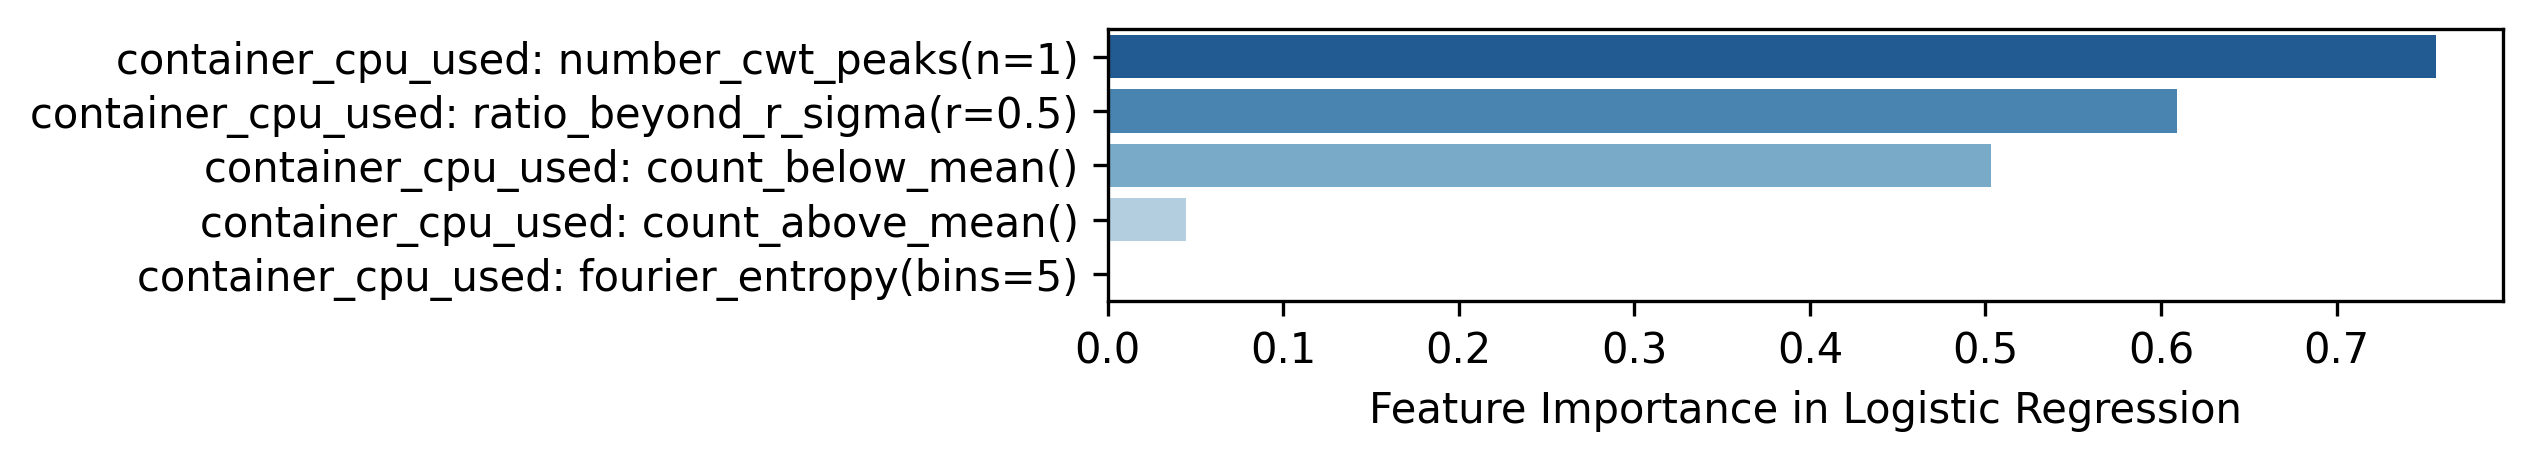

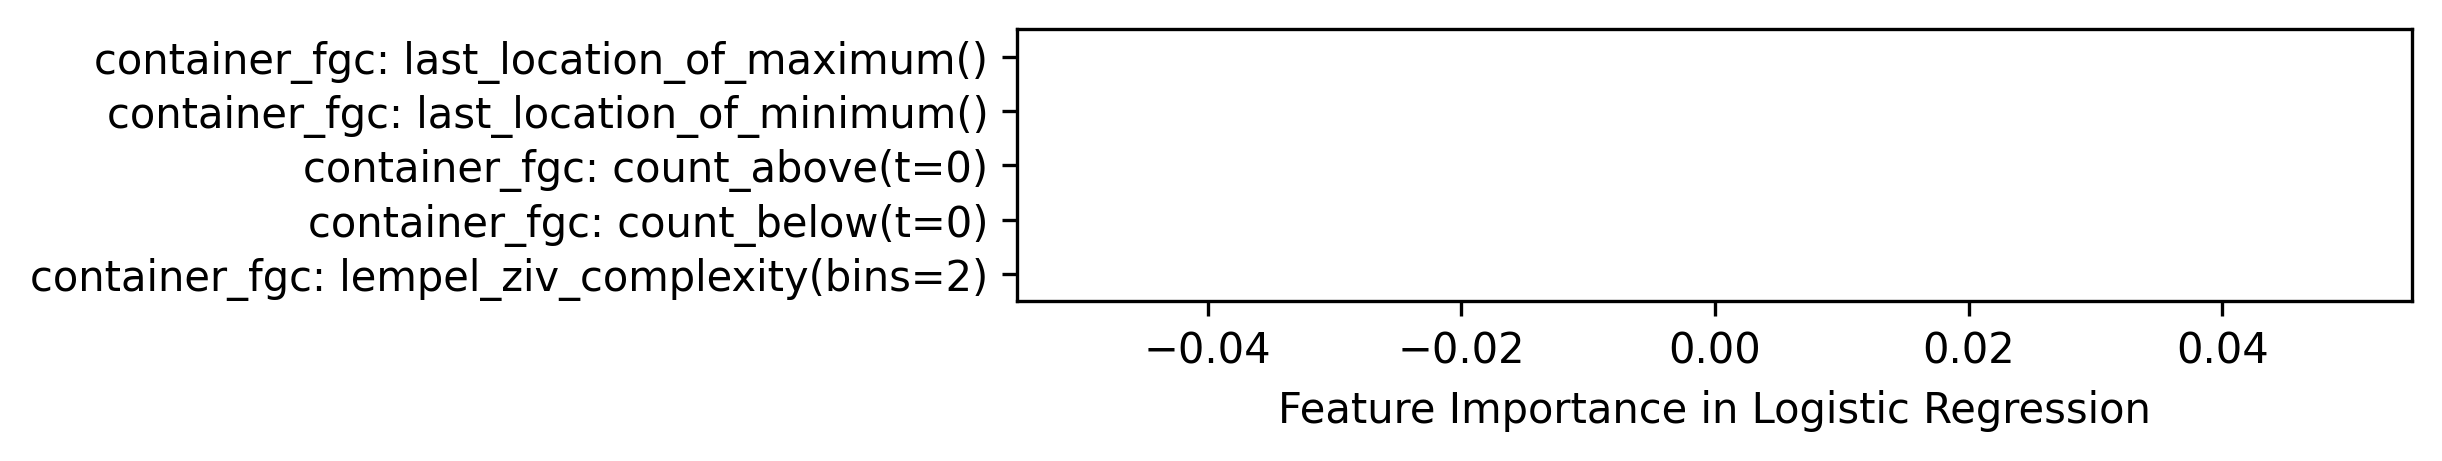

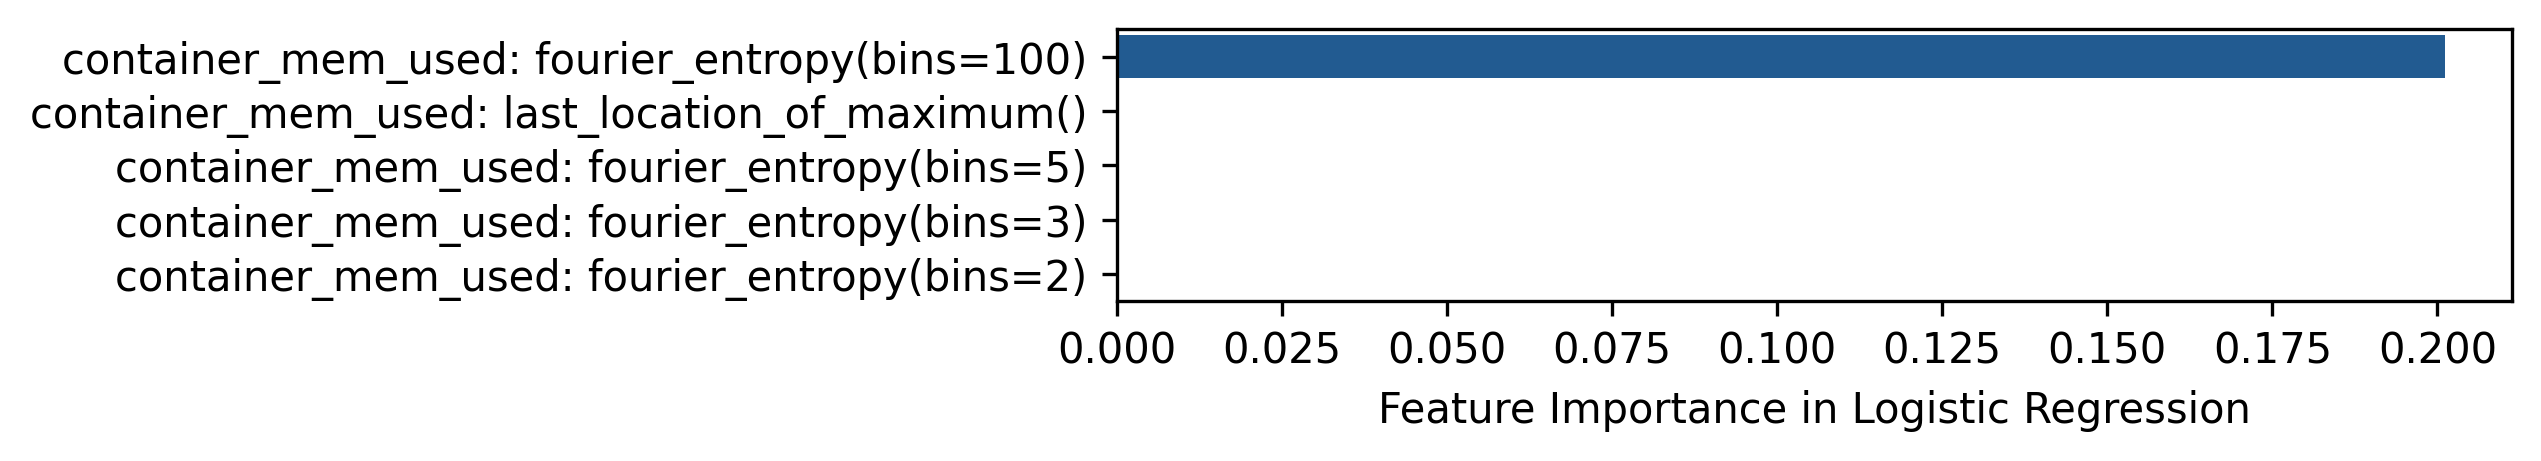

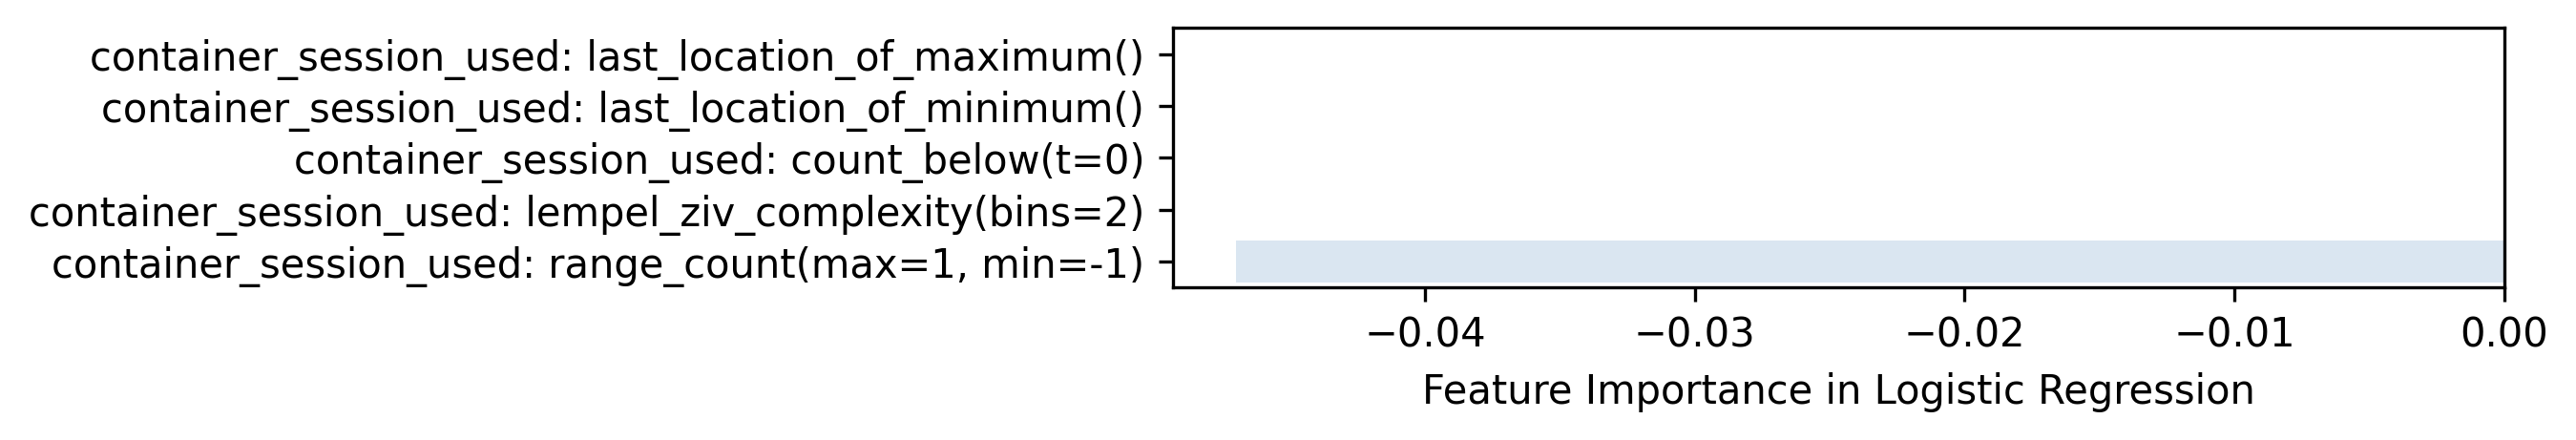

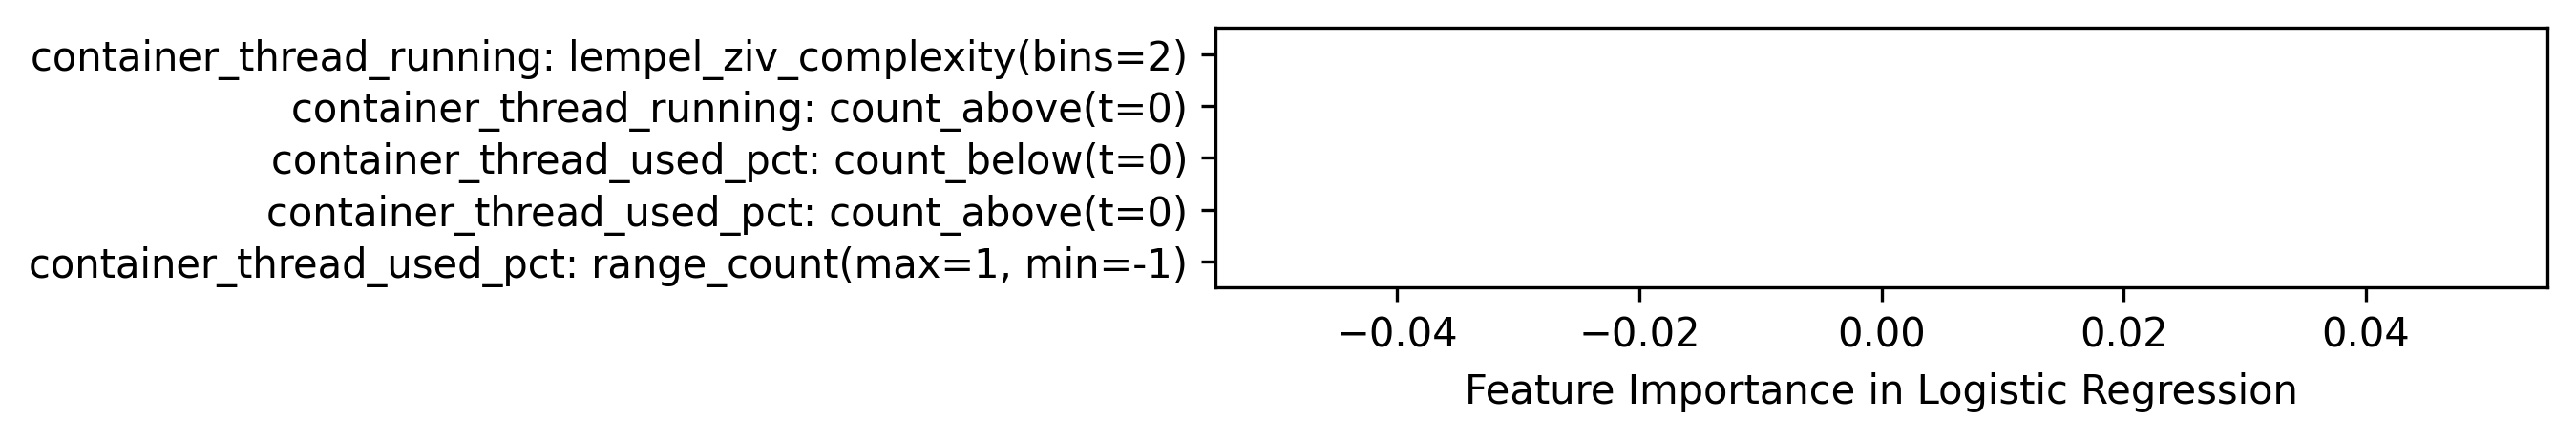

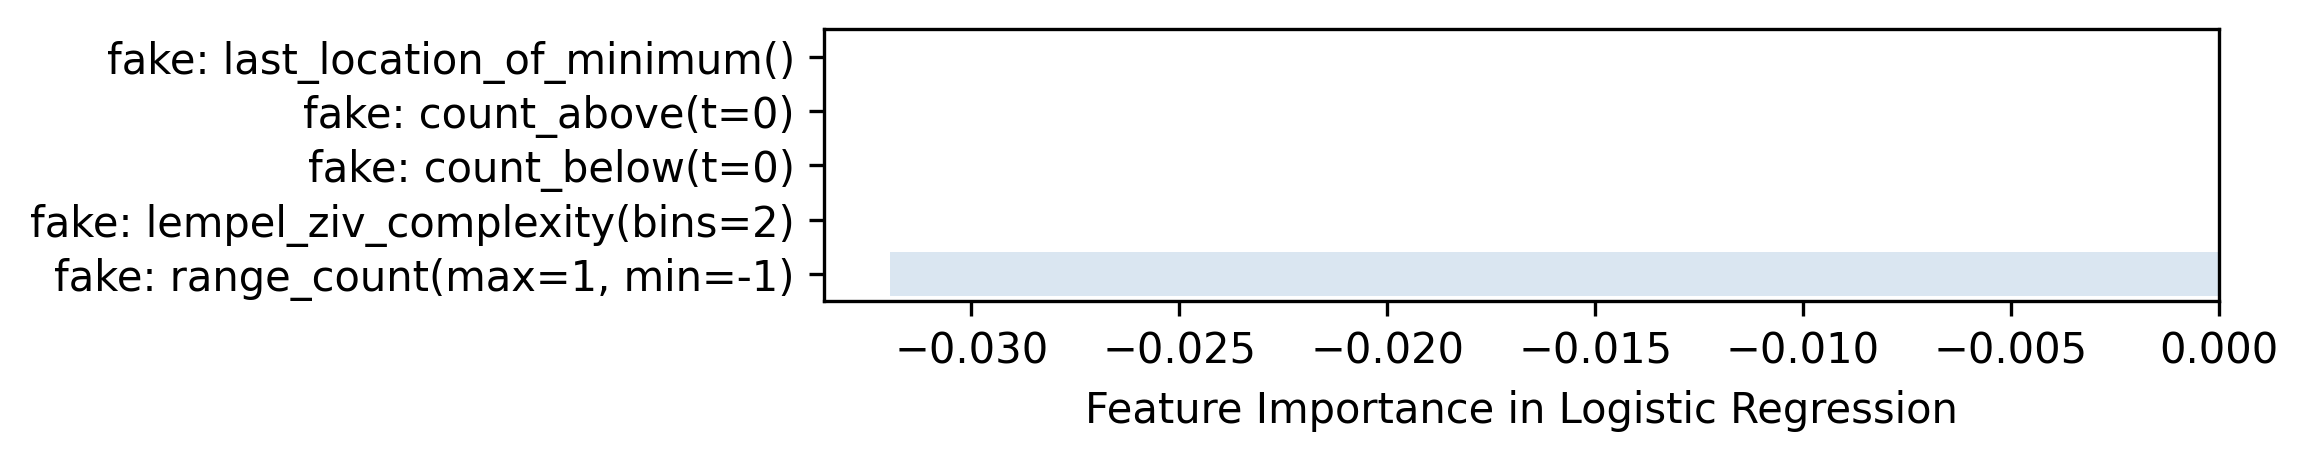

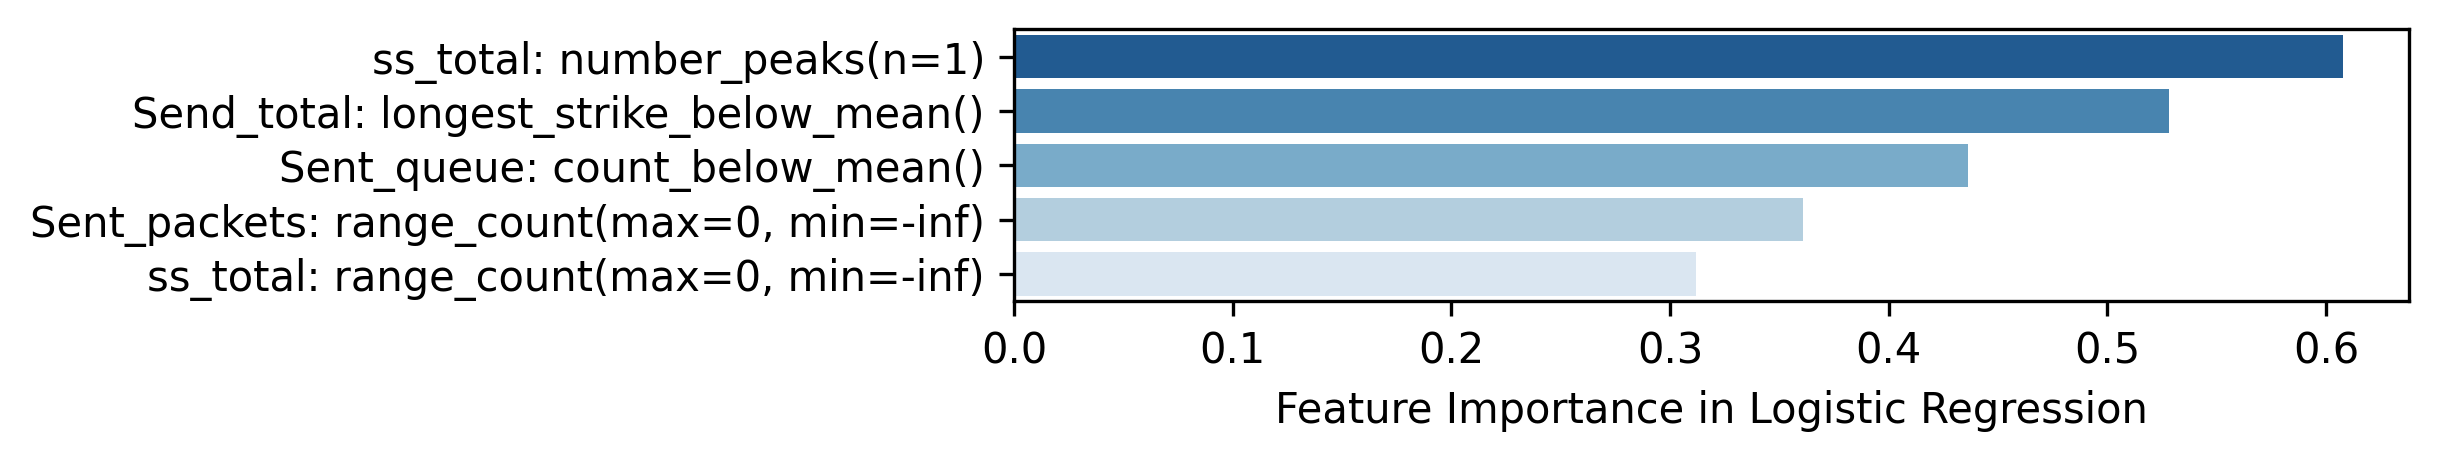

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
def plot_lr_explain_result(feature_importances, k=5):
    def parse(s):
        metric = s.split("__")[0]
        func = s.split("__")[1]
        params = {}
        for item in s.split("__")[2:]:
            k, v = item.split("_")
            if k == "min" and float(v) < -1e9:
                v = "-inf"
            if k == "max" and float(v) > 1e9:
                v = "inf"
            params[k] = v
        return f"{metric}: {func}({', '.join([f'{k}={v}' for k, v in params.items()])})"
    data = pd.DataFrame({"importance": pd.Series(feature_importances)}).sort_values(by="importance", ascending=False)[:k].reset_index()
    data["index"] = data["index"].map(parse)
    fig = plt.figure(dpi=300, figsize=(6, 1.2))
    sns.barplot(data=data, x="importance", y="index", palette="Blues_r")
    plt.ylabel(None)
    plt.xlabel("Feature Importance in Logistic Regression")

for failure_class in fdg.failure_classes:
    try:
        with open(lr_output_dir / f"{failure_class}_feature_importance.json", "r") as f:
            feature_importances = json.load(f)
    except FileNotFoundError:
        continue
    fig = plot_lr_explain_result(feature_importances)
    plt.savefig(lr_output_dir / f"{failure_class.replace(' ', '_')}.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()